In [53]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from anndata import AnnData

         Falling back to preprocessing with `sc.pp.pca` and default params.


/n/fs/ragr-research/users/jh3258/miniconda3/envs/gaston-package/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/n/fs/ragr-research/users/jh3258/miniconda3/envs/gaston-package/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/n/fs/ragr-research/users/jh3258/miniconda3/envs/gaston-package/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


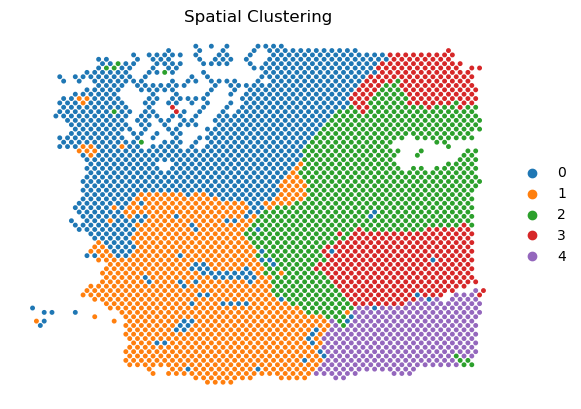

In [63]:
# Load the numpy arrays
counts_mat = np.load('glioblastoma_tumor_data/counts_mat.npy')
coords_mat = np.load('glioblastoma_tumor_data/coords_mat.npy')
gene_labels = np.load('glioblastoma_tumor_data/gene_labels.npy', allow_pickle=True)

# Rotate the spatial coordinates 90 degrees clockwise to align with histology
coords_mat = np.array([coords_mat[:, 1], -coords_mat[:, 0]]).T  # Swap and negate x-coordinates

# Create an AnnData object
adata = AnnData(X=counts_mat)
adata.obsm['spatial'] = coords_mat  # Store spatial coordinates in .obsm
adata.var_names = gene_labels  # Assign gene names

# Normalize and log transform the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Calculate the neighbors (necessary for clustering)
sc.pp.neighbors(adata)

# Perform clustering (using Leiden algorithm)
sc.tl.leiden(adata, resolution=0.2) #0.2

# Plot the rotated clusters
sc.pl.embedding(adata, basis='spatial', color='leiden', 
                title='Spatial Clustering', 
                frameon=False, 
                s=50)

In [ ]:
from sklearn.metrics import adjusted_rand_score

cluster_labels = adata.obs['leiden'] # After performing the Leiden clustering, obtain the labels
gaston_labels = np.load('ST_liver4_tumor_data/gaston_labels.npy') # Load in cluster labels from GASTON

# Compute the Adjusted Rand Score between the two sets of cluster labels
ars_score = adjusted_rand_score(cluster_labels, gaston_labels)

print(f"Adjusted Rand Score: {ars_score:.4f}")

In [90]:
# Identify the indices for clusters correspond to tumor: "1,2,and 3"
# cluster_indices = adata.obs['leiden'].isin(['1', '2', '3']).values
cluster_indices = adata.obs['leiden'].isin(['0','4']).values

# Subset counts matrix
counts_mat_cluster = adata.X[cluster_indices, :]

# Subset coordinates matrix
coords_mat_cluster = adata.obsm['spatial'][cluster_indices, :]

# Load and subset the GLMPCA results
path_to_glmpca ='/n/fs/ragr-data/datasets/GBM_10X_spatial/F_glmpca_penalty_10.npy'
glmpca_mat = np.load(path_to_glmpca)
glmpca_mat_subset = glmpca_mat[cluster_indices, :]

# Save the subsetted matrices
np.save('glioblastoma_tumor_data/counts_mat_cluster_stroma.npy', counts_mat_cluster)
np.save('glioblastoma_tumor_data/coords_mat_cluster_stroma.npy', coords_mat_cluster)
np.save('glioblastoma_tumor_data/F_glmpca_penalty_50_cluster_stroma.npy', glmpca_mat_subset)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/n/fs/ragr-research/users/jh3258/miniconda3/envs/gaston-package/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/n/fs/ragr-research/users/jh3258/miniconda3/envs/gaston-package/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/n/fs/ragr-research/users/jh3258/miniconda3/envs/gaston-package/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


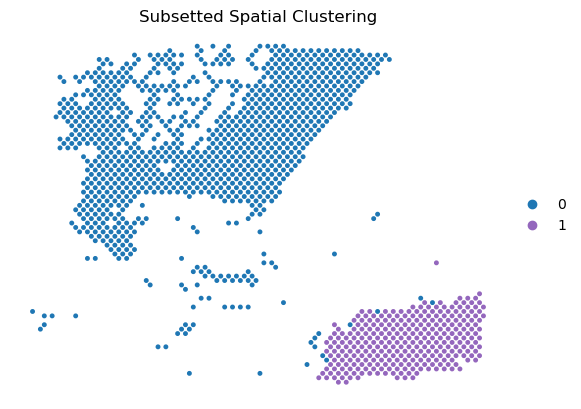

In [96]:
adata_subset = AnnData(X=counts_mat_cluster)
adata_subset.obsm['spatial'] = coords_mat_cluster
adata_subset.var_names = gene_labels

# We need to recalculate neighbors for the new subset AnnData
sc.pp.neighbors(adata_subset)

# We need to re-run the Leiden algorithm to get new cluster labels for the subsetted data
sc.tl.leiden(adata_subset, resolution=0.1)

# Define a custom color palette as a list
custom_palette = ['#1f77b4', '#9467bd']
# '#ff7f0e', '#2ca02c', '#d62728'
# Assign the custom color palette to the 'leiden' clustering in adata_subset
adata_subset.uns['leiden_colors'] = custom_palette

# Finally, we plot the newly subsetted clusters using Scanpy's plotting function
sc.pl.embedding(adata_subset, basis='spatial', color='leiden',
                title='Subsetted Spatial Clustering',
                frameon=False,
                s=50)

In [86]:
import scanpy as sc
from anndata import AnnData

# Assuming adata_subset is already created and neighbors are calculated

# Re-run the Leiden algorithm to get new cluster labels for the subsetted data
sc.tl.leiden(adata_subset, resolution=0.1525)

# Define a custom color palette
# You will need to replace 'color_1', 'color_2', 'color_3' with the actual color codes from your original plot.
custom_palette = {'#ff7f0e','#2ca02c','#d62728'}

# Map the new cluster labels to the colors from the original clusters
# adata_subset.uns['leiden_colors'] = [custom_palette[label] for label in adata_subset.obs['leiden'].cat.categories]

# Now plot using the new color mapping
sc.pl.embedding(adata_subset, basis='spatial', color=custom_palette,
                title='Subsetted Spatial Clustering with Original Colors',
                frameon=False, s=50, palette=adata_subset.uns['leiden_colors'])


KeyError: 'leiden_colors'